# Spatiotemporal Events in Football
## EDA and Data Story Telling

Some of the data files are too large for uploading to github. If you'd like to explore them, with my project code they can be downloaded from the following link. The raw data will need to be run through the code in the data wrangling Jupyter Notebook in the related GitHub repo for this notebook to run successfully.

https://figshare.com/collections/Soccer_match_event_dataset/4415000/3

In [1]:
# load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set_palette('GnBu_d')
from copy import copy

In [2]:
# import data
teams = pd.read_csv('data/premier_league_teams.csv', index_col='teamId')
players = pd.read_csv('data/premier_league_players.csv', index_col='playerId')
ranks = pd.read_csv('data/premier_league_ranks.csv', index_col=['playerId', 'matchId'])
matches = pd.read_csv('data/premier_league_matches.csv')
events = pd.read_csv('data/premier_league_events.csv')

Let’s first explore the team standings at the close of the 2017 season. The figure below shows the total number of wins and is sorted based on team standing. We can see clearly that the number of wins has a strong correlation with where the team finished in the standings, though there are some instances like Southampton where they placed ahead of teams who actually won more matches.

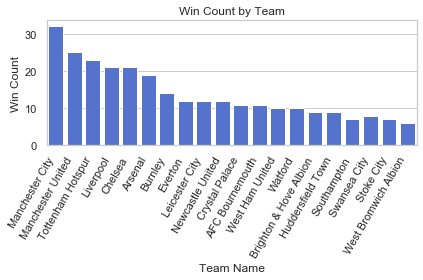

In [4]:
# build dataframe called winners which includes match data, team names and postions
winners = pd.merge(matches, teams[['name', 'position']], left_on='teamId', right_index=True)
# subset to only include wins
winners = winners[winners.outcome == 'W']
# sort by position
winners.sort_values(by=['position'], inplace=True)

# display wins by team rank/position at the end of the season
win_plot = sns.countplot(x='name', data=winners, color='royalblue')
# set x ticks to be the team names
win_plot.set_xticklabels(win_plot.get_xticklabels(), rotation=60, ha='right')
# set title, and x/y labels
plt.title('Win Count by Team')
plt.xlabel('Team Name')
plt.ylabel('Win Count')
plt.tight_layout()
plt.show()

In [5]:
# count the goals for each teamId
goals = matches.groupby(by=['teamId'], as_index=False).goals.sum()
# merge the total goal count back into the teams dataframe
goals = goals.merge(teams[['name','position']], left_on='teamId', right_index=True)
# sort by standing
goals.sort_values(by=['position'], inplace=True)

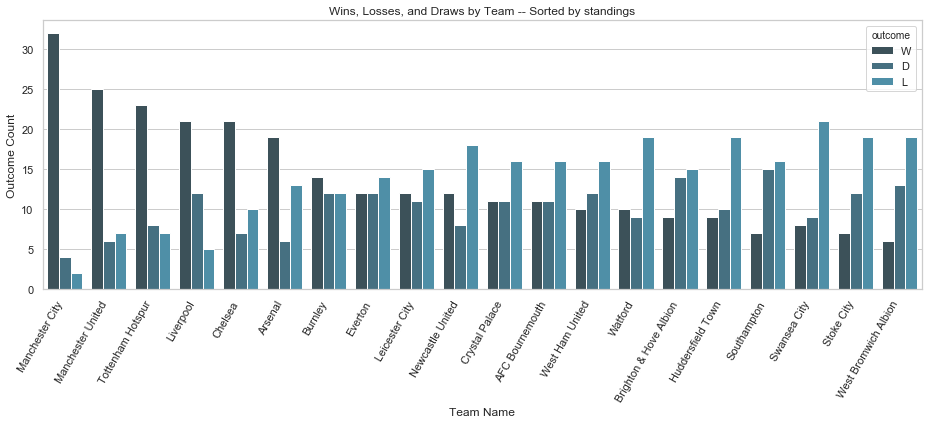

In [6]:
# build dataframe called winners which includes match data, team names and postions
all_outcomes = pd.merge(matches, teams[['name', 'position']], left_on='teamId', right_index=True)
all_outcomes.sort_values('position', inplace=True)

plt.figure(figsize=(13, 6))
all_goals_plot = sns.countplot(x="name", hue="outcome", data=all_outcomes)
all_goals_plot.set_xticklabels(all_goals_plot.get_xticklabels(), rotation=60, ha='right')
# set title, and x/y labels
plt.title('Wins, Losses, and Draws by Team -- Sorted by standings')
plt.xlabel('Team Name')
plt.ylabel('Outcome Count')
plt.tight_layout()
plt.show()

The plot above shows draws and losses in addition to the wins shown in the first plot. We can see that to the left of the plot the wins greatly outweigh draws and losses. Toward the middle of the plot, the three outcomes are all balanced, and toward the right the number of losses starts to outweigh wins and draws.

This is sensible considering the points system used in the premier league which is used to determine team standings. A win is awarded 3 points, a draw 1, and a loss 0 points. Ties in points are decided by goal difference and then by number of goals scored. In this case goal difference is the number of goals a team scored minus the number of goals other teams scored against them.

Now that we’ve looked at the top level performance of each team, let’s explore the events themselves. To start, let’s see which types of events are most common. The plot below shows that passes are the most common type of event, followed by duels and that shots themselves are only the sixth most common type of event. Based on this observation, it is possible that passes and duels may have a larger influence on the outcome of a game than shots themselves. This may be worth considered during feature selection when building predictive models.


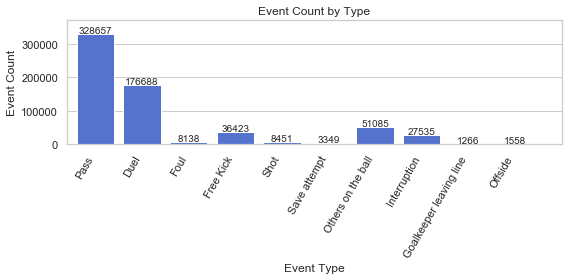

In [26]:
# set figure size
plt.figure(figsize=(8, 4))

# count and plot the number of each major event type
event_count_plot = sns.countplot(events.eventName, color='royalblue')
event_count_plot.set_xticklabels(event_count_plot.get_xticklabels(), rotation=60, ha='right')

# loop through each bar and add annotations for event counts at the top/center of each bar
for p in event_count_plot.patches:
    height = p.get_height()
    event_count_plot.text(p.get_x()+p.get_width()/2., height + 2000,height ,ha="center")

# set x/y lim
plt.xlim(-0.6,10)
plt.ylim(0, 370000)
# set title, and x/y labels
plt.title('Event Count by Type')
plt.xlabel('Event Type')
plt.ylabel('Event Count')

plt.tight_layout()
plt.show()

Now let’s see how the total number of goals scored in a season relates to team standing. The below plot shows that there is more to winning than just the number of goals scored. Liverpool, for example, scored the second most number of goals but still only finished fourth in the season. This could be because they scored many goals in a handful of wins and/or because they finished more games in a tie. Let’s take a closer look.

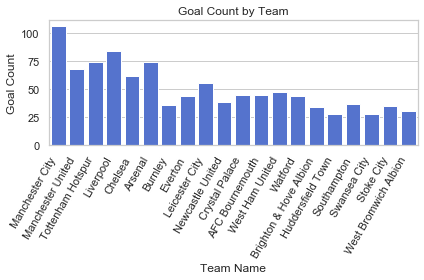

In [8]:
# make plot of total number of goals scored by team, sorted by standing
goals_plot = sns.barplot(x='name', y='goals', data=goals, color='royalblue')
# add x tick labels
goals_plot.set_xticklabels(goals_plot.get_xticklabels(), rotation=60, ha='right')
# set title, and x/y labels
plt.title('Goal Count by Team')
plt.xlabel('Team Name')
plt.ylabel('Goal Count')
plt.tight_layout()
plt.show()

We can also consider the goal difference for each team. The goal difference is calculated by subtracting the number of goals scored against a team by the number of goals that team scored themselves. When we look at a plot of these values sorted by standings we see that the top 6 teams stand out from the other teams in that they have a positive goal difference. This means they've scored more goals than have been scored against them.

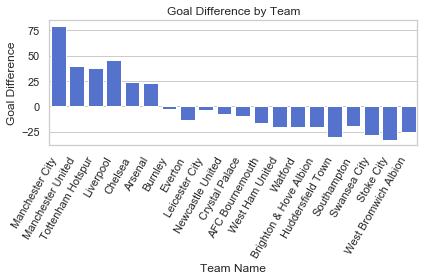

In [9]:
# make plot of goal difference grouped by team sorted by standing
# goal difference is the number of goals scored less the number of goals scored against
gd_plot = sns.barplot(x='name', y='GD', data=teams.sort_values('position'), color='royalblue')
# add x tick labels
gd_plot.set_xticklabels(goals_plot.get_xticklabels(), rotation=60, ha='right')
# set title, and x/y labels
plt.title('Goal Difference by Team')
plt.xlabel('Team Name')
plt.ylabel('Goal Difference')
plt.tight_layout()
plt.show()

Now let’s consider the total number of events throughout the season by team. Below we see that the top six teams were involved in more events overall than the rest of the field, with the exception of Southampton. This seems to suggest that these teams are dominant and maintain possession of the ball more than the other teams. 

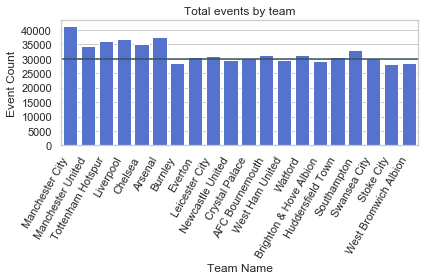

In [10]:
#event_count = events.teamId.value_counts()
event_count = pd.DataFrame({'numEvents':events.teamId.value_counts()})
event_count = event_count.merge(teams[['name', 'position']], left_index=True, right_index=True)
event_count.sort_values('position', inplace=True)
# make plot of goal difference grouped by team sorted by standing
# goal difference is the number of goals scored less the number of goals scored against
eventNum_plot = sns.barplot(x='name', y='numEvents', data=event_count, color='royalblue')
eventNum_plot.set_xticklabels(eventNum_plot.get_xticklabels(), rotation=60, ha='right')
eventNum_plot.axhline(y=30000)

# set title, and x/y labels
plt.title('Total events by team')
plt.xlabel('Team Name')
plt.yticks(np.arange(0, 45000, step=5000))
plt.ylabel('Event Count')

plt.tight_layout()
plt.show()

Rather than just considering the total count, let’s explore the distribution of events across the field. We'll start by comparing the distribution of events across the field for Manchester City, who finished first, and West Bromwich Albion, who finished last.

There is some variation in the exact size of the playing field across the premier league. As such, all x and y positions are reported as percentages of the field. The x-y origin is set as the lower left hand corner and all play occurs with the attack heading toward the right. This is a necessary form of normalization because teams switch sides half way through the game and change directions. By making the attack always play to the right it assures that all plays to the right of the midway point are offensive and all plays to the left of the midway point are defensive.

Here we see that it appears that West Bromwich Albion (WBA) has a higher density of events in the backfield where they are on the defence whereas Manchester city has a bias toward the attack. We especially see this is true in the defending goal box where WBA has more occurences of their total events whereas Manchester city has relatively few. We can also see that WBA has a high density in the top right corner which indicates a large number of corner kicks. These are awarded to a team when the ball goes out of bounds last touched by their opponent at the opponent’s own end of the field. In this case it may be an indication of WBA not being able to convert potential offensive opportunities to shots but rather having the ball stolen and/or deflected out of bounds.

In [11]:
def fieldLayoutElements():
    ''' function to set size of field elements for plotting
        builds list of all elements and returns it
        the dimensions are based off of typical premier league regulations'''
    # the actual size of the footbal pitch varies by stadium, here we'll use a common size of 105x68m
    pitch_length = 105
    pitch_width = 68
    # set penalty area length ratio, palr and penalty area width ratio, pawr
    palr = 16.5 / pitch_length
    pawr = 40.32 / pitch_width
    # set goal area length ratio, galr and goal area width ratio, gawr
    galr = 5.5 / pitch_length
    gawr = 18.32 / pitch_width
    # set goal depth ratio, gdr and goal width ratio, gwr
    gdr = 2.44 / pitch_length
    gwr = 7.32 / pitch_width

    # set the size of each box/area rectangle
    penalty_area = patches.Rectangle((100 - 100*palr, 50 - 50*pawr), 100*palr, 100*pawr, fill=False, color='Black')
    goal_area = patches.Rectangle((100 - 100*galr, 50 - 50*gawr), 100*galr, 100*gawr, fill=False, color='Black')
    goal_box = patches.Rectangle((100, 50 - 50*gwr), 100*gdr, 100*gwr, fill=False, color='Black')
    
    # build a list of all elements to be returned
    field_elements = [penalty_area, goal_area, goal_box]
    return field_elements
    

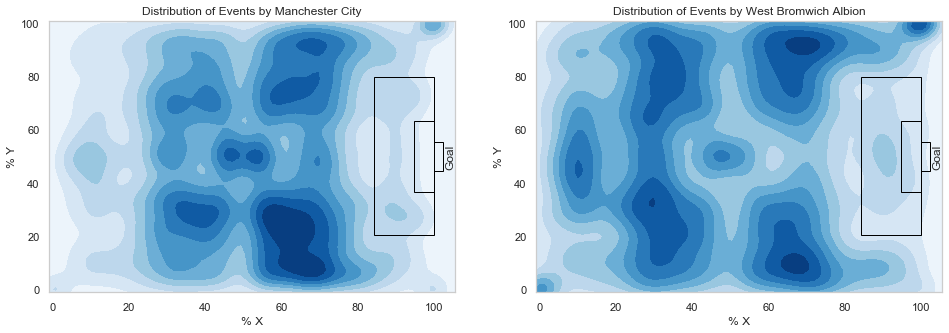

In [12]:
# set figure size
plt.figure(figsize=(16, 5))

# store the man city id from teams
mc_id = teams[teams.name == 'Manchester City'].index[0]
mc_pos = events[events.teamId == mc_id]

# set the subplot
plt.subplot(1, 2, 1)
mc_plot = sns.kdeplot(mc_pos.start_x, mc_pos.start_y, cmap='Blues', shade=True)

# load field elements to be plotted
field_elements = fieldLayoutElements()

# plot a copy of each field element onto the subplot
for box in field_elements:
    new_box=copy(box)
    mc_plot.add_patch(new_box)

# set x/y labels and limits, add goal annotation and title
plt.xlabel('% X')
plt.xlim(-1,105.5)
plt.ylabel('% Y')
plt.ylim(-1,101)
plt.text(103, 50, 'Goal', fontsize=12, verticalalignment='center', rotation=90)
plt.title('Distribution of Events by Manchester City')

# set the subplot
plt.subplot(1, 2, 2)

# store the West Bromwich Albion id from teams
wba_id = teams[teams.name == 'West Bromwich Albion'].index[0]
wba_pos = events[events.teamId == wba_id]
wba_plot = sns.kdeplot(wba_pos.start_x, wba_pos.start_y, cmap='Blues', shade=True)

# plot a copy of each field element onto the subplot
for box in field_elements:
    new_box=copy(box)
    wba_plot.add_patch(new_box)

# set x/y labels and limits, add goal annotation and title
plt.xlabel('% X')
plt.xlim(-1,105.5)
plt.ylabel('% Y')
plt.ylim(-1,101)
plt.text(103, 50, 'Goal', fontsize=12, verticalalignment='center', rotation=90)
plt.title('Distribution of Events by West Bromwich Albion')
plt.show()

The above plots show trends as it relates to entire teams. Let's take a closer look and compare two individual players. In this case let's compare Harry Kane and Mohamed Salah -- two leading forwards in the league.

It is clear that Mo Salah prefers to play toward the top end of the pitch and the top left corner of the goal box. This is very different from Harry Kane who appears to play a more centered game and has a larger presence in the center of the goal box. For reference, Mo Salah led the league with 32 goals this season while Harry Kane scored 30 goals.

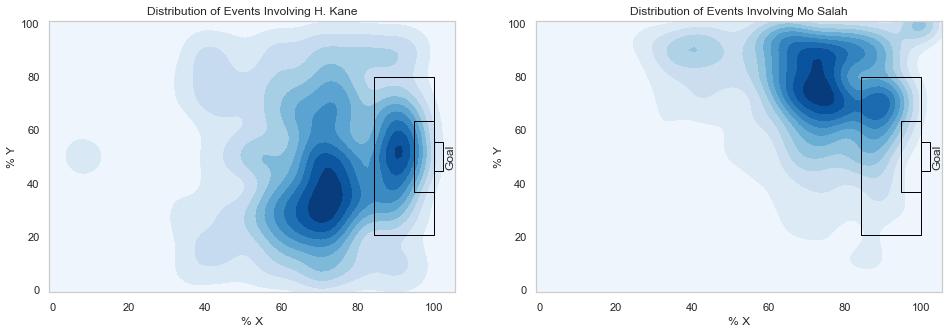

In [13]:
# set figure size
plt.figure(figsize=(16, 5))

# set the subplot
plt.subplot(1, 2, 1)

# find the index for harry kane
hk_id = players[players.shortName == 'H. Kane'].index[0]
# use index to find his playerId
hk_pos = events[events.playerId == hk_id]
# generate kde plot of events involving harry kane
hk_plot = sns.kdeplot(hk_pos.start_x, hk_pos.start_y, cmap='Blues', shade=True)

# load field elements to be plotted
field_elements = fieldLayoutElements()

# plot a copy of each field element onto the subplot
for box in field_elements:
    new_box=copy(box)
    hk_plot.add_patch(new_box)
    
# set x/y labels and limits, add goal annotation and title
plt.xlabel('% X')
plt.xlim(-1,105.5)
plt.ylabel('% Y')
plt.ylim(-1,101)
plt.text(103, 50, 'Goal', fontsize=12, verticalalignment='center', rotation=90)
plt.title('Distribution of Events Involving H. Kane')

# set the subplot
plt.subplot(1, 2, 2)

# find the index for Mohamed (Mo) Salah
mo_id = players[players.shortName == 'Mohamed Salah'].index[0]
# use index to find his playerId
mo_pos = events[events.playerId == mo_id]
# generate kde plot of events involving mo salah
mo_plot = sns.kdeplot(mo_pos.start_x, mo_pos.start_y, cmap='Blues', shade=True)

# plot a copy of each field element onto the subplot
for box in field_elements:
    new_box=copy(box)
    mo_plot.add_patch(new_box)

# set x/y labels and limits, add goal annotation and title
plt.xlabel('% X')
plt.xlim(-1,105.5)
plt.ylabel('% Y')
plt.ylim(-1,101)
plt.text(103, 50, 'Goal', fontsize=12, verticalalignment='center', rotation=90)
plt.title('Distribution of Events Involving Mo Salah')
plt.show()

One hypothesis I have is that goals are more likely when the passes leading to them occur rapidly. To start exploring this, let's look at the distribution of intervals between events. This is simply the difference in the time each event was logged. The histogram below shows a gamma distribution with a median value of 2.058 seconds. This shows that most events are relatively short to begin with gives context for what length of interval should be considered rapid. 

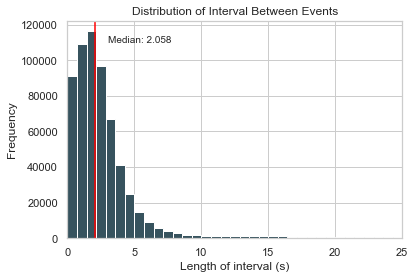

In [14]:
# drop the interval outliers. these include unusually long events which are most often due to interruptions
# penalty kicks, and generally not representative of normal, dynamic game play
drop_intervals = events[(events.interval < 25) & (events.interval != 0)]

# plot a histogram showing the distribution of the observed intervals
_ = plt.hist(drop_intervals.interval, bins=35)

# calculate the median
median = np.median(drop_intervals.interval)
# add a vertical line at the median value and add label
_ = plt.axvline(x=median, color='Red')
median_text = 'Median: ' + str(f"{median:.3f}")
_ = plt.text(3, 110000, median_text, size='medium')

# add title and set x/y labels
_ = plt.title('Distribution of Interval Between Events')
_ = plt.xlabel('Length of interval (s)')
_ = plt.xlim(0,25)
_ = plt.ylabel('Frequency')
plt.show()


Previously we explored how goal count and goal difference correlated with the final standing of each team. Let's take a closer look at the details of the goal events themselves. Below we see that the percentage of goals scored is much smaller than the number of shots attempted. Only about 25% of shots result in a goal. This unbalance should be taken into consideration later when building predictive models. 

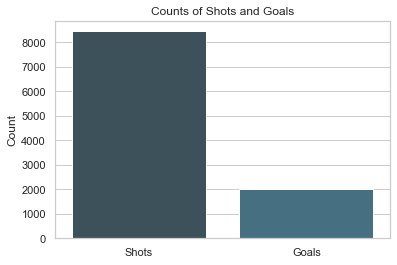

In [15]:
# count the number of goals
goal_count = np.sum(events.goal == 1)
# count the number of shots
shot_count = np.sum(events.eventName == 'Shot')
# make bar plot comparing shots and goals
gc_plot = sns.barplot(x=['Shots','Goals'], y=[shot_count, goal_count])

# add title and set x/y labels
plt.title('Counts of Shots and Goals')
plt.ylabel('Count')
plt.show()

One potentially interesting observation is the region of the goal the ball enters as it breaks the plane of the goal. Picture dividing the goal into bins arranged in a 3x3 grid and labeling it from the attacking player's position. Vertically we label the bins low, center and high. Horizontally we label the bins left, center, and right. We then count the number of goals that enter each bin.

Here we see that most goals are scored in the lower third of the goal and the least goals are scored in the upper third of the goal. The left-to-right distribution is fairly balanced. The lower left bin has slightly more goals than the other bins in the lower portion of the goal.

It is unclear if these trends are simply a result of the number of shots taken at each region. Further investigation comparing the percentage of misses in the various regions around the goal will provide more insight.

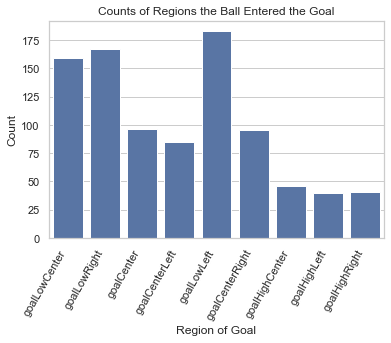

In [16]:
# filter shots from events
shots = events[events.eventName == 'Shot']
# filter goals from events
goals = shots[shots.goal==1]
# slice all columns between and including goalLowCenter through goalHightRight
goals_pos = goals.loc[:,'goalLowCenter':'goalHighRight']
# melt goals_pos to favor making count plot
melt_goals = goals_pos.melt(value_vars=goals_pos.columns)
# set value of each to 1 for counting
melt_goals = melt_goals[melt_goals.value==1]

# make countplot of melted dataframe
goal_region = sns.countplot(data=melt_goals, x='variable', color='b')
# set x tick labels to match column names, add rotation and alight to right
goal_region.set_xticklabels(goal_region.get_xticklabels(), rotation=60, ha='right')

# add title and x/y labels
plt.title('Counts of Regions the Ball Entered the Goal')
plt.xlabel('Region of Goal')
plt.ylabel('Count')
plt.show()

The plot below shows the location of every shot and every goal. It is clear that a higher percentage of goals are made when the shots are taken closer to the goal. This is sensible both because the player shooting the ball should have an easier time aiming and hitting their target from a shorter distance. In addition, the goal keeper and defensive players will have less time to react to the ball before it reaches the goal line. Another observation is that the shots and goals are centered vertically relative to the goal. In fact most shots are taken within the y bounds of the penalty area.

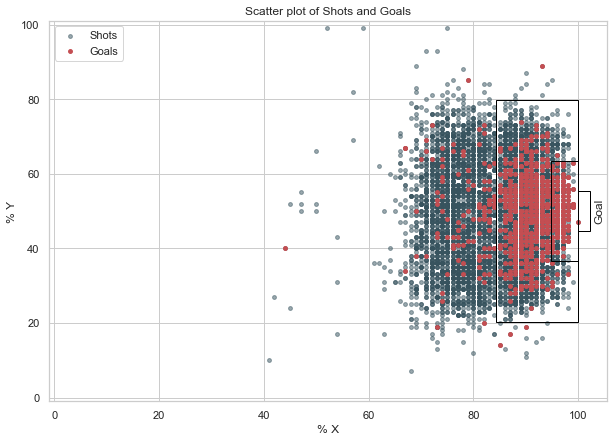

In [17]:
# initialize figure and set figsize
f, ax = plt.subplots(figsize=(10, 7))

# find x and y positions of each shot
x = shots.start_x
y = shots.start_y
# plot position of each shot
goal_scatter = plt.scatter(x, y, s=15, alpha=0.5, label='Shots')

# find x and y positions of each goal
x2 = goals.start_x
y2 = goals.start_y
# plot position of each goal
goal_scatter = plt.scatter(x2, y2, s=15, c='r', label='Goals')

# plot a copy of each field element onto the subplot
for box in field_elements:
    new_box=copy(box)
    ax.add_patch(new_box)

# add goal annotation
plt.text(103, 50, 'Goal', fontsize=12, verticalalignment='center', rotation=90)
    
# set x/y labels and limits, add goal annotation and title
plt.xlabel('% X')
plt.xlim(-1,105.5)
plt.ylabel('% Y')
plt.ylim(-1,101)
plt.title('Scatter plot of Shots and Goals')
# add legend
plt.legend(loc='upper left')
plt.show()

Next let's explore if the frequency of goals changes over time. Below is a swarm plot showing the timing of each goal scored where the data are grouped by period. It is clear that overall more goals are scored in the second half of the game than in the first. This may be a result of players fatiguing over time and the defence making more mistakes which ultimately result in more goals.

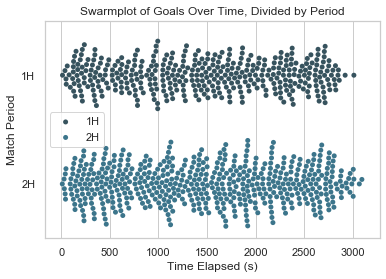

In [18]:
# make swarm plot of goals over time grouped by match period
sns.swarmplot(x=goals.eventSec, y=goals.matchPeriod)

# add title and legend
plt.title('Swarmplot of Goals Over Time, Divided by Period')
plt.legend(['1H', '2H'], loc='center left')
# set x/y labels
plt.xlabel('Time Elapsed (s)')
plt.ylabel('Match Period')
plt.show()

Looking into this in more detail we see that almost 60% of goals are scored in the second period.

In [19]:
# count number of goals by period
goals_by_period = events.groupby(['matchPeriod'])['goal'].sum()

tot_goals = goals_by_period['1H'] + goals_by_period['2H']
goal_ratio1 = goals_by_period['1H'] / tot_goals
goal_ratio2 = goals_by_period['2H'] / tot_goals
print('Ratio of goals in 1st period:', goal_ratio1)
print('Ratio of goals in 2nd period:', goal_ratio2)

Ratio of goals in 1st period: 0.4190333831589437
Ratio of goals in 2nd period: 0.5809666168410563


Below is a work in progress for exploring the x/y position of strings of events leading up to goals. More work is required and this will be revisited later if time allows.

In [20]:
def eventString (eventId, num_events=5):
    '''function to return the previous 'num_events' from a given event '''
    # find the index of the eventId
    eventIndex = events.index[events.id == eventId][0]
    # calculate the index of the event num_events before eventId
    backIndex = eventIndex - num_events
    # return a slice of events df between backIndex through eventIndex
    return events.iloc[backIndex:eventIndex + 1,:]

def plotSequence (eventId, num_events=5):
    '''function to return dataframe of the XY coordinates of a previous 'num_events' from a given event''' 
    # call eventString function to find the sequence of interest
    sequence = eventString(eventId, num_events)
    
    # initialize lists for x and y positions of events
    x_list = []
    y_list = []
    
    # loop through event sequence and append x and y positions for the start and end position 
    # of each event to the desired lists
    for event in sequence.index:
        x_list.append(sequence['start_x'][event])
        x_list.append(sequence['end_x'][event])
        y_list.append(sequence['start_y'][event])
        y_list.append(sequence['end_y'][event])
    # remove the last event from the list. the last event for each goal is just 0,0 or 100, 100
    # depending on if the home or away team scores and is not relevant to the x,y of the actual events
    del x_list[-1]
    del y_list[-1]
    
    # return line plot of the x and y position lists
    return plt.plot(x_list, y_list)



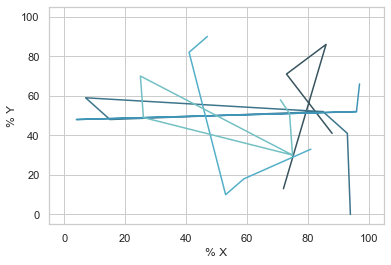

In [21]:
plotSequence(177959212, num_events=3)
plotSequence(177959247, num_events=3)
plotSequence(177959280, num_events=3)
plotSequence(177959289, num_events=3)
plotSequence(177959429, num_events=3)
plt.xlabel('% X')
plt.xlim(-5,105)
plt.ylabel('% Y')
plt.ylim(-5,105)
plt.show()